In [4]:
import pandas as pd
import numpy as np
from shutil import copy
from glob import glob
from bokeh.models import HoverTool, ColumnDataSource, OpenURL, TapTool
from bokeh import palettes
from bokeh.plotting import figure,save
from bokeh.io import show, output_notebook, output_file
from bokeh.transform import linear_cmap
from bokeh_scripts import RS_img, img_ext
from bokeh.layouts import gridplot

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
import astropy.units as u

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
# nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]
# nog102 = []

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [3]:
src1 = ColumnDataSource(data = {'id':mdb.id,'S1':np.log10(mdb.Sigma1), 'z50':cosmo.lookback_time(mdb.z_50),
    'z50p':mdb.z_50, 't50':mdb.t_50, 'sSFR':mdb.log_ssfr, 'zgrism':cosmo.lookback_time(mdb.zgrism),
    'zgrismp':mdb.zgrism, 'Re':mdb.Re, 'lmass':mdb.lmass, 'tq':mdb.t_50-mdb.t_90})

zs = cosmo.lookback_time([2,3,4,5,6,7]).value
zg = cosmo.lookback_time([0.7, 1.0, 1.3, .16, 1.9, 2.2]).value

In [9]:
# output_file('../../Vince-ec.github.io/appendix/appendix.html')

S1 = figure(plot_width=550, plot_height=320, title='Appendix #####', x_axis_label ='log(Sigma_1 (M/kpc^2))',
          y_axis_label = 'z_50 (z)', tools = "tap,pan,wheel_zoom,box_zoom,reset, lasso_select")
sSFR = figure(plot_width=550, plot_height=320, title=None, x_axis_label ='log(sSFR (yr^-1))',
          y_axis_label = 't_50 (Gyr)', tools = "tap,pan,wheel_zoom,box_zoom,reset, lasso_select")
zgz5 = figure(plot_width=550, plot_height=320, title=None, x_axis_label ='z_grism (z)',
          y_axis_label = 't_Q (Gyr)', tools = "tap,pan,wheel_zoom,box_zoom,reset, lasso_select")
smass = figure(plot_width=550, plot_height=320, title=None, x_axis_label ='log(M)',
          y_axis_label = 'R_eff (kpc)', tools = "tap,pan,wheel_zoom,box_zoom,reset, lasso_select",y_axis_type="log")

colors1 = linear_cmap(field_name='sSFR', palette=palettes.Spectral6 ,low=min(mdb.log_ssfr) ,
                      high=max(mdb.log_ssfr))
colors2 = linear_cmap(field_name='zgrism', palette=palettes.Spectral6 ,low=min(mdb.zgrism) ,
                      high=max(mdb.zgrism))

S1.circle(source=src1, x='S1', y='z50',size=15, color="firebrick", alpha=0.5, 
          hover_color="black")
# S1.scatter(source=src1, x='S1', y='z50',size=15,fill_color=colors1, fill_alpha=0.6, 
#           hover_color="black")
# # S1.scatter(source=src1, x='S1', y='z50',size=15,fill_color=colors2, fill_alpha=0.6, 
# #           hover_color="black")

sSFR.scatter(source=src1, x='sSFR', y='t50',size=15, color="firebrick", alpha=0.5, 
          hover_color="black",)
zgz5.scatter(source=src1, x='zgrism', y='tq',size=15, color="firebrick", alpha=0.5, 
          hover_color="black",)
smass.scatter(source=src1, x='lmass', y='Re',size=15, color="firebrick", alpha=0.5, 
          hover_color="black",)

# S1.legend.location = "bottom_left"
# S1.legend.click_policy="mute"


S1.add_tools(HoverTool(tooltips = [('ID', '@id'), ('log(Sigma_1)', '@S1'), ('z50', '@z50p'), ('zgrism', '@zgrismp')] ))
sSFR.add_tools(HoverTool(tooltips = [('ID', '@id'), ('sSFR', '@sSFR'), ('t50', '@t50')] ))
zgz5.add_tools(HoverTool(tooltips = [('ID', '@id'), ('zgrism', '@zgrismp'), ('t_Q', '@tq')] ))
smass.add_tools(HoverTool(tooltips = [('ID', '@id'), ('log(M)', '@lmass'), ('R_eff', '@Re')] ))

sSFR.xaxis.axis_label_text_font_size=S1.xaxis.axis_label_text_font_size="12pt"
sSFR.yaxis.axis_label_text_font_size=S1.yaxis.axis_label_text_font_size="12pt"
sSFR.xaxis.major_label_text_font_size=S1.xaxis.major_label_text_font_size="10pt"
sSFR.yaxis.major_label_text_font_size=S1.yaxis.major_label_text_font_size="10pt"
zgz5.xaxis.axis_label_text_font_size=smass.xaxis.axis_label_text_font_size="12pt"
zgz5.yaxis.axis_label_text_font_size=smass.yaxis.axis_label_text_font_size="12pt"
zgz5.xaxis.major_label_text_font_size=smass.xaxis.major_label_text_font_size="10pt"
zgz5.yaxis.major_label_text_font_size=smass.yaxis.major_label_text_font_size="10pt"

S1.yaxis.ticker = zs
S1.yaxis.major_label_overrides = {zs[0]:'2',zs[1]:'3',zs[2]:'4',zs[3]:'5',zs[4]:'6',zs[5]:'7'}
zgz5.xaxis.ticker = zg
zgz5.xaxis.major_label_overrides = {zg[0]:'0.7',zg[1]:'1.0',zg[2]:'1.3',zg[3]:'1.6',zg[4]:'1.9',zg[5]:'2.2'}

url = "https://vince-ec.github.io/appendix/sfhs/@id.html"
taptool1 = S1.select(type=TapTool)
taptool1.callback = OpenURL(url=url)
taptool2 = sSFR.select(type=TapTool)
taptool2.callback = OpenURL(url=url)
taptool3 = zgz5.select(type=TapTool)
taptool3.callback = OpenURL(url=url)
taptool4 = smass.select(type=TapTool)
taptool4.callback = OpenURL(url=url)
# save(gridplot([[S1, sSFR], [zgz5, smass]]))
output_notebook()
show(gridplot([[S1, sSFR], [zgz5, smass]]))


Loading BokehJS ...

In [15]:
import pickle
from spec_tools import Gen_SFH

for idx in mdb.index:

    with open('../data/SFH/{}_{}_1D.pkl'.format( mdb.field[idx],  mdb.id[idx]), 'rb') as sfh_file:
        SFH = pickle.load(sfh_file)

    IMG = RS_img(img_ext(mdb.field[idx], mdb.id[idx]))
    zs = [z_at_value(cosmo.lookback_time,(U*u.Gyr + cosmo.lookback_time(mdb.zgrism[idx])), zmax=1E6) for U in SFH.LBT]


    src_sfh = ColumnDataSource(data = {'LBT':SFH.LBT,'SFH':SFH.SFH, 
                                       'z':zs })

    img = figure(plot_width=300, plot_height=350, x_range=(0, 10), y_range=(0, 10), 
                 title = '{}-{}'.format(mdb.field[idx], mdb.id[idx]))
    img.image(image=[IMG[::-1]*-1], x=0, y=0, dw=10, dh=10,palette=palettes.gray(100))
    img.title.text_font_size = "20pt"
    img.xaxis.major_label_text_color = img.yaxis.major_label_text_color = None
    img.yaxis.major_tick_line_color = img.xaxis.major_tick_line_color =None 
    img.yaxis.minor_tick_line_color = img.xaxis.minor_tick_line_color =None 

    sfh = figure(plot_width = 600, plot_height = 350, x_axis_label ='Lookback Time (Gyr)',
              y_axis_label = 'SFR')
    for i in range(100):
        sfh.line(SFH.fulltimes,SFH.sfr_grid[i], color = '#532436', alpha=.075)

    r1 = sfh.line(source = src_sfh, x = 'LBT', y='SFH', color = '#C1253C')
    sfh.line(SFH.LBT,SFH.SFH_16, color ='black')
    sfh.line(SFH.LBT,SFH.SFH_84, color ='black')

    sfh.add_tools(HoverTool(tooltips = [('Lookback time', '@LBT'), ('SFH', '@SFH'), ('z', '@z')], renderers = [r1]))
    sfh.xaxis.axis_label_text_font_size = "20pt"
    sfh.yaxis.axis_label_text_font_size = "20pt"

    output_file('../../Vince-ec.github.io/appendix/sfhs/{}.html'.format(mdb.id[idx]))

    save(gridplot([[img, sfh]]))  

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/astropy/cosmology/funcs.py:122: UserWarning: fval is not bracketed by func(zmin) and func(zmax). This means either
there is no solution, or that there is more than one solution between
zmin and zmax satisfying fval = func(z).
  zmin and zmax satisfying fval = func(z).""")


In [5]:
import pickle
from spec_tools import Gen_SFH

idx = 2 
with open('../data/SFH/{}_{}_1D.pkl'.format( mdb.field[idx],  mdb.id[idx]), 'rb') as sfh_file:
    SFH = pickle.load(sfh_file)

IMG = RS_img(img_ext(mdb.field[idx], mdb.id[idx]))
zs = [z_at_value(cosmo.lookback_time,(U*u.Gyr + cosmo.lookback_time(mdb.zgrism[idx])), zmax=1E6) for U in SFH.LBT]


src_sfh = ColumnDataSource(data = {'LBT':SFH.LBT,'SFH':SFH.SFH, 
                                   'z':zs })

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/astropy/cosmology/funcs.py:122: UserWarning: fval is not bracketed by func(zmin) and func(zmax). This means either
there is no solution, or that there is more than one solution between
zmin and zmax satisfying fval = func(z).
  zmin and zmax satisfying fval = func(z).""")


In [14]:
img = figure(plot_width=300, plot_height=350, x_range=(0, 10), y_range=(0, 10), 
             title = '{}-{}'.format(mdb.field[idx], mdb.id[idx]))
img.image(image=[IMG[::-1]*-1], x=0, y=0, dw=10, dh=10,palette=palettes.gray(100))
img.title.text_font_size = "20pt"
img.xaxis.major_label_text_color = img.yaxis.major_label_text_color = None
img.yaxis.major_tick_line_color = img.xaxis.major_tick_line_color =None 
img.yaxis.minor_tick_line_color = img.xaxis.minor_tick_line_color =None 

sfh = figure(plot_width = 600, plot_height = 350, x_axis_label ='Lookback Time (Gyr)',
          y_axis_label = 'SFR (M/yr)')
for i in range(100):
    sfh.line(SFH.fulltimes,SFH.sfr_grid[i], color = '#532436', alpha=.075)

r1 = sfh.line(source = src_sfh, x = 'LBT', y='SFH', color = '#C1253C')
sfh.line(SFH.LBT,SFH.SFH_16, color ='black')
sfh.line(SFH.LBT,SFH.SFH_84, color ='black')

sfh.add_tools(HoverTool(tooltips = [('Lookback time', '@LBT'), ('SFH', '@SFH'), ('z', '@z')], renderers = [r1]))
sfh.xaxis.axis_label_text_font_size = "20pt"
sfh.yaxis.axis_label_text_font_size = "20pt"
sfh.xaxis.major_label_text_font_size = "15pt"
sfh.yaxis.major_label_text_font_size = "15pt"
output_notebook()
show(gridplot([[img, sfh]]))

Loading BokehJS ...

In [29]:
import os
flist = glob('../appendix/sfhs/*')

for f in flist:
    copy(f, '../appendix/sfhs/' + os.path.basename(f)[4:])    

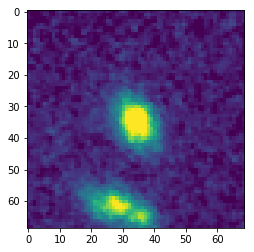

In [12]:
import matplotlib.pyplot as plt

plt.imshow(IMG[::-1])
plt.show()